# All oscillation analysis

Brief 1-2 sentence description of notebook.

In [1]:
# Imports of all used packages and libraries
import sys
import os
import git
import glob
from collections import defaultdict

In [2]:
git_repo = git.Repo(".", search_parent_directories=True)
git_root = git_repo.git.rev_parse("--show-toplevel")

In [3]:
git_root

'/nancy/user/riwata/projects/reward_comp_ext'

In [4]:
sys.path.insert(0, os.path.join(git_root, 'src'))

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
import os
import collections
import itertools
from collections import defaultdict
from itertools import combinations

In [7]:
# Imports of all used packages and libraries
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import mannwhitneyu


In [8]:
import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import colorsys

In [9]:
from sklearn.metrics import confusion_matrix

In [10]:
from spectral_connectivity import Multitaper, Connectivity
import spectral_connectivity

In [11]:
import utilities.helper
import trodes.read_exported

In [12]:
FONTSIZE = 20

In [13]:
font = {'weight' : 'medium',
        'size'   : 20}

matplotlib.rc('font', **font)

## Inputs & Data

In [14]:
EPHYS_SAMPLE_RATE = 20000

Explanation of each input and where it comes from.

In [15]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case
OUTPUT_DIR = r"./proc/" # where data is saved should always be shown in the inputs
os.makedirs(OUTPUT_DIR, exist_ok=True)
OUTPUT_PREFIX = "rce_pilot_3_alone_comp"

In [16]:
# TRIAL_LABELS_DF = pd.read_excel("/blue/npadillacoreano/ryoi360/projects/reward_comp/repos/reward_comp_ext/results/2024_06_26_sleap_clustering/data/rce_pilot_3_alone_comp_per_video_trial_labels.xlsx")
TRIALS_AND_SPECTRAL_DF = pd.read_pickle("./proc/rce_pilot_3_alone_comp_10_per_trial_spectral_bans_sleap.pkl")

In [17]:
FULL_LFP_TRACES_PKL = "{}_12_per_cluster_spectral_bans_sleap.pkl".format(OUTPUT_PREFIX)

## Outputs

Describe each output that the notebook creates. 

- Is it a plot or is it data?

- How valuable is the output and why is it valuable or useful?

## Functions 

In [18]:
def combine_dicts(dicts):
    """
    Combine lists from multiple dictionaries that share the same key.

    This function takes a list of dictionaries where each dictionary's values are lists of numbers.
    It merges these lists for each corresponding key across all dictionaries, producing a single
    dictionary where each key has a combined list of all numbers from the input dictionaries.

    Parameters:
        dicts (list of dict): A list of dictionaries with values as lists of numbers.

    Returns:
        dict: A dictionary with keys from the input dictionaries and values as merged lists 
        of numbers from all corresponding input dictionary values.
    """
    combined = defaultdict(list)
    for dictionary in dicts:
        for key, value in dictionary.items():
            combined[key].extend(value)
    
    return dict(combined)


# Example usage
list_of_dicts = [
    {'a': [1, 2], 'b': [3, 4]},
    {'a': [5], 'b': [6, 7]},
    {'a': [8, 9], 'c': [10]}
]

combined_dict = combine_dicts(list_of_dicts)
print(combined_dict)

{'a': [1, 2, 5, 8, 9], 'b': [3, 4, 6, 7], 'c': [10]}


In [19]:
def find_consecutive_ranges(numbers, min_length=1):
    """
    Finds the start and end indices for consecutive ranges of each number in a list where the range meets a minimum length.

    This function iterates through a list of integers and identifies ranges where the same integer appears consecutively
    and the length of this sequence meets or exceeds the specified minimum length.

    Parameters:
        numbers (list): A list of integers to analyze for consecutive ranges.
        min_length (int): The minimum length of a range for it to be included in the results.

    Returns:
        dict: A dictionary with integers as keys and a list of tuples (start, end) as values,
              where each tuple represents the start and end indices (inclusive) of consecutive ranges
              for that integer. Only ranges that meet or exceed the minimum length are included.
    """
    ranges = {}
    n = len(numbers)
    if n == 0:
        return ranges
    
    start = 0
    current = numbers[0]

    for i in range(1, n):
        if numbers[i] != current:
            if (i - start) >= min_length:
                if current not in ranges:
                    ranges[current] = []
                ranges[current].append((start, i - 1))
            current = numbers[i]
            start = i

    # Handle the last range
    if (n - start) >= min_length:
        if current not in ranges:
            ranges[current] = []
        ranges[current].append((start, n - 1))

    return ranges

# Example usage:
numbers = [1, 1, 2, 2, 2, 3, 3, 3, 3, 2, 2, 1, 1]
print(find_consecutive_ranges(numbers, min_length=3))

{2: [(2, 4)], 3: [(5, 8)]}


In [20]:
def update_tuples_in_dict(original_dict, reference_list):
    """
    Updates the values in the tuples within a dictionary by replacing indices with corresponding values from a reference list.
    
    This function iterates through each key-value pair in the original dictionary. Each value is expected to be a list of tuples,
    where each tuple contains indices. These indices are used to fetch corresponding values from the reference list, creating new tuples.
    
    Parameters:
        original_dict (dict): Dictionary whose values are lists of tuples. Each tuple consists of indices into the reference_list.
        reference_list (list): List of elements that are referenced by the indices in the tuples of the original_dict.
        
    Returns:
        dict: A dictionary with the same keys as original_dict but with tuples transformed to contain elements from reference_list
              based on the indices in the original tuples.
    """
    # Create a new dictionary to store the updated key-value pairs
    new_dict = {}
    for key, list_of_tuples in original_dict.items():
        # Process each tuple in the list associated with the current key
        updated_tuples = [
            tuple(reference_list[idx] for idx in tup) for tup in list_of_tuples
        ]
        new_dict[key] = updated_tuples
    
    return new_dict

# Example usage:
original_dict = {
    'a': [(0, 1), (2, 3)],
    'b': [(1, 3), (0, 2)]
}
reference_list = ['alpha', 'beta', 'gamma', 'delta']

updated_dict = update_tuples_in_dict(original_dict, reference_list)
print(updated_dict)

{'a': [('alpha', 'beta'), ('gamma', 'delta')], 'b': [('beta', 'delta'), ('alpha', 'gamma')]}


In [21]:
def find_indices_within_ranges(ranges_dict, values):
    """
    Creates a dictionary mapping keys to sorted indices of values that fall within specified ranges.
    
    Parameters:
        ranges_dict (dict): A dictionary with keys and values as lists of tuples representing ranges.
        values (list): A list of values to check against the ranges.
        
    Returns:
        dict: A dictionary where each key maps to a sorted list of indices for values within the ranges.
    """
    result_dict = {}
    for key, ranges in ranges_dict.items():
        matched_indices = []
        for index, value in enumerate(values):
            if any(start <= value <= end for start, end in ranges):
                matched_indices.append(index)
        result_dict[key] = sorted(matched_indices)
    return list(result_dict.items())

# Example usage:
ranges_dict = {
    'range1': [(1, 5), (10, 15)],
    'range2': [(0, 2), (4, 8)]
}
values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

result = find_indices_within_ranges(ranges_dict, values)
print(result)


[('range1', [1, 2, 3, 4, 5, 10, 11, 12, 13, 14, 15]), ('range2', [0, 1, 2, 4, 5, 6, 7, 8])]


## Processing

Describe what is done to the data here and how inputs are manipulated to generate outputs. 

In [22]:
# As much code and as many cells as required
# includes EDA and playing with data
# GO HAM!

# Ideally functions are defined here first and then data is processed using the functions

# function names are short and in snake case all lowercase
# a function name should be unique but does not have to describe the function
# doc strings describe functions not function names




## Renaming the trial labels

In [23]:
TRIALS_AND_SPECTRAL_DF.head()

,tone_start_frame,reward_start,reward_dispensed,tone_stop_frame,condition,competition_closeness,get_reward_frame,out_reward_frame,notes,box_1_port_entry_frames,...,trial_and_post_mPFC_gamma_phase,trial_and_post_mPFC_lfp_trace,trial_and_post_mPFC_theta_band,trial_and_post_mPFC_theta_phase,trial_and_post_vHPC_gamma_band,trial_and_post_vHPC_gamma_phase,trial_and_post_vHPC_lfp_trace,trial_and_post_vHPC_theta_band,trial_and_post_vHPC_theta_phase,trial_and_post_lfp_timestamps
0,34242.0,34322,34342.0,34442.0,4.3,After trial,NaN,NaN,NaN,[34250 34265],...,"[-2.8267386, -2.5752828, -2.3241265, -2.073247...","[74.295, 59.67, 49.53, 71.174995, 98.865, 105....","[0.45963967, 0.46584538, 0.4714166, 0.47629145...","[0.0660045, 0.100497134, 0.13558412, 0.1712443...","[-0.33073074, -0.2819916, -0.21614309, -0.1376...","[-2.721211, -2.4700835, -2.2192981, -1.9688195...","[100.424995, 94.38, 89.7, 106.274994, 127.1399...","[0.5714821, 0.57240754, 0.5722418, 0.57094795,...","[0.16306445, 0.20337772, 0.24396515, 0.2848233...","[34280580, 34280600, 34280620, 34280640, 34280..."
1,34242.0,34322,34342.0,34442.0,4.3,After trial,NaN,NaN,NaN,[34250 34265],...,"[-2.4468, -2.2177749, -1.9918119, -1.7689933, ...","[19.695, 43.68, 68.25, 87.16499, 101.204994, 9...","[0.6209574, 0.6194976, 0.6152875, 0.6083768, 0...","[-0.14499341, -0.07693758, -0.008636221, 0.059...","[0.005282254, 0.024448069, 0.041276596, 0.0541...","[-1.484184, -1.164493, -0.85072726, -0.5423021...","[-6.24, 8.384999, 61.815, 109.005, 125.774994,...","[0.51433784, 0.4935799, 0.47049338, 0.44517246...","[0.5733892, 0.64060175, 0.7075213, 0.7741529, ...","[34280580, 34280600, 34280620, 34280640, 34280..."
2,35241.0,35321,35341.0,35439.0,4.3,Subj 2 Only,NaN,NaN,NaN,[35242 35249] [35249 35250] [35250 35271] [353...,...,"[-1.3393176, -1.0746405, -0.8121532, -0.552019...","[-42.12, -46.019997, -42.899998, -34.515, -29....","[-0.55376214, -0.54105306, -0.5277178, -0.5138...","[-2.848622, -2.809103, -2.7699904, -2.7312958,...","[0.033837054, 0.08063326, 0.120246336, 0.15044...","[-1.3934808, -1.129738, -0.86815214, -0.608863...","[-65.13, -52.065, -46.215, -45.045, -38.024998...","[-0.51730657, -0.50465643, -0.49131757, -0.477...","[-2.8382177, -2.7967052, -2.75556, -2.7147894,...","[35280600, 35280620, 35280640, 35280660, 35280..."
3,35241.0,35321,35341.0,35439.0,4.3,Subj 2 Only,NaN,NaN,NaN,[35242 35249] [35249 35250] [35250 35271] [353...,...,"[1.1835573, 1.3989904, 1.6151469, 1.8322233, 2...","[-84.24, -29.64, 8.969999, -31.005, -109.395, ...","[-0.43594536, -0.40849745, -0.37993425, -0.350...","[-2.290331, -2.2391956, -2.18775, -2.1359916, ...","[0.032845914, 0.01358331, -0.008819404, -0.033...","[1.2072978, 1.4309896, 1.6569884, 1.884983, 2....","[-74.1, -20.865, 18.33, -21.644999, -101.39999...","[-0.45931047, -0.42667648, -0.3932578, -0.3591...","[-2.2182832, -2.1700776, -2.1216602, -2.073028...","[35280600, 35280620, 35280640, 35280660, 35280..."
4,36339.0,36419,36439.0,36538.0,4.3,Subj 2 blocking Subj 1,NaN,NaN,NaN,[36339 36354] [36361 36365] [36410 36473] [364...,...,"[1.9263768, 2.1613147, 2.397383, 2.634575, 2.8...","[7.995, 11.7, 12.674999, 5.85, -11.8949995, -3...","[0.04354602, 0.04824548, 0.050688196, 0.050923...","[-1.434966, -1.4083124, -1.3854433, -1.3673644...","[-0.17820239, -0.24864225, -0.30498573, -0.344...","[2.0645847, 2.298156, 2.5328636, 2.768695, 3.0...","[22.814999, 32.37, 31.005, 12.674999, -14.4299...","[0.007989262, 0.015576166, 0.021102728, 0.0245...","[-1.5463593, -1.5198455, -1.4966478, -1.477523...","[36380600, 36380620, 36380640, 36380660, 36380..."


In [24]:
comp_closeness_dict = {'Subj 1 blocking Subj 2': "competitive",
'Subj 2 Only': "no_comp",
'Subj 2 blocking Subj 1': "competitive",
'Subj 1 then Subj 2': "competitive", 
'Subj 1 Only': "no_comp",
'Subj 2 then Subj 1': "competitive",
'Close Call': "competitive",
'After trial': "no_comp"}

In [25]:
TRIALS_AND_SPECTRAL_DF["current_subject"] = TRIALS_AND_SPECTRAL_DF["current_subject"].apply(lambda x: str(x).strip().lower())

In [26]:
TRIALS_AND_SPECTRAL_DF["condition "] = TRIALS_AND_SPECTRAL_DF["condition "].apply(lambda x: str(x).strip().lower())

In [27]:
TRIALS_AND_SPECTRAL_DF["trial_label"] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: "win" if x["current_subject"] == x["condition "]  else ("lose" if x["agent"] == x["condition "] else "tie"), axis=1)
                                                                        

In [28]:
TRIALS_AND_SPECTRAL_DF["competition_closeness"] = TRIALS_AND_SPECTRAL_DF["competition_closeness"].map(comp_closeness_dict)

In [29]:
TRIALS_AND_SPECTRAL_DF["trial_label"]

0      lose
1       win
2      lose
3       win
4      lose
       ... 
243     win
244    lose
245     win
246     tie
247     tie
Name: trial_label, Length: 248, dtype: object

## Getting the ranges of each cluster

- Getting the index range

In [30]:
list(TRIALS_AND_SPECTRAL_DF.columns)

['tone_start_frame',
 'reward_start',
 'reward_dispensed',
 'tone_stop_frame',
 'condition ',
 'competition_closeness',
 'get_reward_frame',
 'out_reward_frame',
 'notes',
 'box_1_port_entry_frames',
 'box_2_port_entry_frames',
 'video_name',
 'tone_start_timestamp',
 'tone_stop_timestamp',
 'box_1_port_entry_timestamps',
 'box_2_port_entry_timestamps',
 'current_subject',
 'subject_tail_base',
 'agent_tail_base',
 'session_dir',
 'experiment',
 'sleap_name',
 'video_id',
 'agent',
 'all_subjects',
 'coherence_calculation_frequencies',
 'cohort',
 'first_timestamp',
 'granger_calculation_frequencies',
 'last_timestamp',
 'power_calculation_frequencies',
 'recording',
 'session_path',
 'subject',
 'tone_frames',
 'tone_timestamps',
 'video_timestamps',
 'baseline_start_timestamp',
 'post_trial_end_timestamp',
 'video_frame',
 'trial_and_post_agent_locations',
 'trial_and_post_agent_nose',
 'trial_and_post_agent_nose_to_reward_port',
 'trial_and_post_agent_thorax',
 'trial_and_post_agent

In [31]:
TRIALS_AND_SPECTRAL_DF["cluster_index_ranges_dict"] = TRIALS_AND_SPECTRAL_DF["trial_and_post_kmeans_cluster"].apply(lambda x: find_consecutive_ranges(x, min_length=20))


In [32]:
TRIALS_AND_SPECTRAL_DF["cluster_index_ranges_dict"].iloc[0]

{5: [(4, 44), (58, 228), (281, 304)], 1: [(254, 280)], 2: [(358, 381)]}

In [33]:
TRIALS_AND_SPECTRAL_DF.head()

,tone_start_frame,reward_start,reward_dispensed,tone_stop_frame,condition,competition_closeness,get_reward_frame,out_reward_frame,notes,box_1_port_entry_frames,...,trial_and_post_mPFC_theta_band,trial_and_post_mPFC_theta_phase,trial_and_post_vHPC_gamma_band,trial_and_post_vHPC_gamma_phase,trial_and_post_vHPC_lfp_trace,trial_and_post_vHPC_theta_band,trial_and_post_vHPC_theta_phase,trial_and_post_lfp_timestamps,trial_label,cluster_index_ranges_dict
0,34242.0,34322,34342.0,34442.0,4.3,no_comp,NaN,NaN,NaN,[34250 34265],...,"[0.45963967, 0.46584538, 0.4714166, 0.47629145...","[0.0660045, 0.100497134, 0.13558412, 0.1712443...","[-0.33073074, -0.2819916, -0.21614309, -0.1376...","[-2.721211, -2.4700835, -2.2192981, -1.9688195...","[100.424995, 94.38, 89.7, 106.274994, 127.1399...","[0.5714821, 0.57240754, 0.5722418, 0.57094795,...","[0.16306445, 0.20337772, 0.24396515, 0.2848233...","[34280580, 34280600, 34280620, 34280640, 34280...",lose,"{5: [(4, 44), (58, 228), (281, 304)], 1: [(254..."
1,34242.0,34322,34342.0,34442.0,4.3,no_comp,NaN,NaN,NaN,[34250 34265],...,"[0.6209574, 0.6194976, 0.6152875, 0.6083768, 0...","[-0.14499341, -0.07693758, -0.008636221, 0.059...","[0.005282254, 0.024448069, 0.041276596, 0.0541...","[-1.484184, -1.164493, -0.85072726, -0.5423021...","[-6.24, 8.384999, 61.815, 109.005, 125.774994,...","[0.51433784, 0.4935799, 0.47049338, 0.44517246...","[0.5733892, 0.64060175, 0.7075213, 0.7741529, ...","[34280580, 34280600, 34280620, 34280640, 34280...",win,"{5: [(4, 44), (58, 228), (281, 304)], 1: [(254..."
2,35241.0,35321,35341.0,35439.0,4.3,no_comp,NaN,NaN,NaN,[35242 35249] [35249 35250] [35250 35271] [353...,...,"[-0.55376214, -0.54105306, -0.5277178, -0.5138...","[-2.848622, -2.809103, -2.7699904, -2.7312958,...","[0.033837054, 0.08063326, 0.120246336, 0.15044...","[-1.3934808, -1.129738, -0.86815214, -0.608863...","[-65.13, -52.065, -46.215, -45.045, -38.024998...","[-0.51730657, -0.50465643, -0.49131757, -0.477...","[-2.8382177, -2.7967052, -2.75556, -2.7147894,...","[35280600, 35280620, 35280640, 35280660, 35280...",lose,"{5: [(10, 31)], 6: [(32, 67)], 1: [(115, 161),..."
3,35241.0,35321,35341.0,35439.0,4.3,no_comp,NaN,NaN,NaN,[35242 35249] [35249 35250] [35250 35271] [353...,...,"[-0.43594536, -0.40849745, -0.37993425, -0.350...","[-2.290331, -2.2391956, -2.18775, -2.1359916, ...","[0.032845914, 0.01358331, -0.008819404, -0.033...","[1.2072978, 1.4309896, 1.6569884, 1.884983, 2....","[-74.1, -20.865, 18.33, -21.644999, -101.39999...","[-0.45931047, -0.42667648, -0.3932578, -0.3591...","[-2.2182832, -2.1700776, -2.1216602, -2.073028...","[35280600, 35280620, 35280640, 35280660, 35280...",win,"{5: [(10, 31)], 6: [(32, 67)], 1: [(115, 161),..."
4,36339.0,36419,36439.0,36538.0,4.3,competitive,NaN,NaN,NaN,[36339 36354] [36361 36365] [36410 36473] [364...,...,"[0.04354602, 0.04824548, 0.050688196, 0.050923...","[-1.434966, -1.4083124, -1.3854433, -1.3673644...","[-0.17820239, -0.24864225, -0.30498573, -0.344...","[2.0645847, 2.298156, 2.5328636, 2.768695, 3.0...","[22.814999, 32.37, 31.005, 12.674999, -14.4299...","[0.007989262, 0.015576166, 0.021102728, 0.0245...","[-1.5463593, -1.5198455, -1.4966478, -1.477523...","[36380600, 36380620, 36380640, 36380660, 36380...",lose,"{3: [(10, 29)], 1: [(108, 130), (329, 350), (3..."


In [34]:
TRIALS_AND_SPECTRAL_DF["cluster_timestamp"] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: x["video_timestamps"][x["trial_and_post_frame_index"]], axis=1)


- Calculating the times in milliseconds of each cluster frame

In [35]:
TRIALS_AND_SPECTRAL_DF["cluster_times"] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: (np.array(x["cluster_timestamp"]) - x["first_timestamp"]) // 20, axis=1)


- Updating the index to use cluster times and timestamps based on video frame timestamps list

In [36]:
TRIALS_AND_SPECTRAL_DF["cluster_times_ranges_dict"] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: update_tuples_in_dict(x["cluster_index_ranges_dict"], x["cluster_times"]), axis=1)

In [37]:
TRIALS_AND_SPECTRAL_DF["cluster_timestamps_ranges_dict"] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: update_tuples_in_dict(x["cluster_index_ranges_dict"], x["cluster_timestamp"]), axis=1)

- Combining the win and loss label with the cluster

In [38]:
TRIALS_AND_SPECTRAL_DF["trial_cluster_times_ranges_dict"] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: {"{}_{}".format(x["trial_label"], k): v for k, v in x["cluster_times_ranges_dict"].items()}, axis=1)


In [39]:
TRIALS_AND_SPECTRAL_DF["trial_cluster_timestamps_ranges_dict"] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: {"{}_{}".format(x["trial_label"], k): v for k, v in x["cluster_timestamps_ranges_dict"].items()}, axis=1)


In [40]:
TRIALS_AND_SPECTRAL_DF["trial_cluster_timestamps_ranges_dict"].iloc[0]

{'lose_5': [(34285025, 34325215), (34339074, 34509536), (34562199, 34585759)],
 'lose_1': [(34535867, 34562199)],
 'lose_2': [(34639808, 34661982)]}

In [41]:
TRIALS_AND_SPECTRAL_DF.columns

Index(['tone_start_frame', 'reward_start', 'reward_dispensed',
       'tone_stop_frame', 'condition ', 'competition_closeness',
       'get_reward_frame', 'out_reward_frame', 'notes',
       'box_1_port_entry_frames',
       ...
       'trial_and_post_vHPC_theta_phase', 'trial_and_post_lfp_timestamps',
       'trial_label', 'cluster_index_ranges_dict', 'cluster_timestamp',
       'cluster_times', 'cluster_times_ranges_dict',
       'cluster_timestamps_ranges_dict', 'trial_cluster_times_ranges_dict',
       'trial_cluster_timestamps_ranges_dict'],
      dtype='object', length=211)

In [42]:
TRIALS_AND_SPECTRAL_DF["trial_and_post_coherence_timestamps"].iloc[0]

array([34290000, 34300000, 34310000, 34320000, 34330000, 34340000,
       34350000, 34360000, 34370000, 34380000, 34390000, 34400000,
       34410000, 34420000, 34430000, 34440000, 34450000, 34460000,
       34470000, 34480000, 34490000, 34500000, 34510000, 34520000,
       34530000, 34540000, 34550000, 34560000, 34570000, 34580000,
       34590000, 34600000, 34610000, 34620000, 34630000, 34640000,
       34650000, 34660000, 34670000, 34680000])

In [43]:
timestamps_col = [col for col in TRIALS_AND_SPECTRAL_DF.columns if "timestamps" in col and "trial_and_post" in col and "video" not in col]

In [44]:
timestamps_col

['trial_and_post_coherence_timestamps',
 'trial_and_post_granger_timestamps',
 'trial_and_post_power_timestamps',
 'trial_and_post_lfp_timestamps']

- Getting all the indexes that fit within each range

In [45]:
for col in timestamps_col:
    base_col = col.replace("trial_and_post_", "")
    TRIALS_AND_SPECTRAL_DF["cluster_filtered_{}".format(base_col)] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: find_indices_within_ranges(x["trial_cluster_timestamps_ranges_dict"], x[col]), axis=1)

# Filtering for power

In [46]:
TRIALS_AND_SPECTRAL_DF = TRIALS_AND_SPECTRAL_DF[TRIALS_AND_SPECTRAL_DF["cluster_filtered_power_timestamps"].apply(lambda x: len(x)) >= 1] 

In [ ]:
# Define columns to be transformed into numpy arrays
array_columns = ['Feature1', 'Feature2']
# Define columns to take the first value
first_value_columns = ['Metadata1', 'Metadata2']

# Define aggregation dictionary
agg_dict = {col: lambda x: np.array(x) for col in array_columns}
agg_dict.update({col: 'first' for col in first_value_columns})

# Apply groupby and aggregation
grouped_df = df.groupby('Group').agg(agg_dict).reset_index()

print(grouped_df)

In [48]:
list(TRIALS_AND_SPECTRAL_DF.columns)

['tone_start_frame',
 'reward_start',
 'reward_dispensed',
 'tone_stop_frame',
 'condition ',
 'competition_closeness',
 'get_reward_frame',
 'out_reward_frame',
 'notes',
 'box_1_port_entry_frames',
 'box_2_port_entry_frames',
 'video_name',
 'tone_start_timestamp',
 'tone_stop_timestamp',
 'box_1_port_entry_timestamps',
 'box_2_port_entry_timestamps',
 'current_subject',
 'subject_tail_base',
 'agent_tail_base',
 'session_dir',
 'experiment',
 'sleap_name',
 'video_id',
 'agent',
 'all_subjects',
 'coherence_calculation_frequencies',
 'cohort',
 'first_timestamp',
 'granger_calculation_frequencies',
 'last_timestamp',
 'power_calculation_frequencies',
 'recording',
 'session_path',
 'subject',
 'tone_frames',
 'tone_timestamps',
 'video_timestamps',
 'baseline_start_timestamp',
 'post_trial_end_timestamp',
 'video_frame',
 'trial_and_post_agent_locations',
 'trial_and_post_agent_nose',
 'trial_and_post_agent_nose_to_reward_port',
 'trial_and_post_agent_thorax',
 'trial_and_post_agent

In [63]:
to_keep_columns = ['trial_label',
'tone_start_frame',
'reward_start',
'reward_dispensed',
'tone_stop_frame',
'condition ',
'competition_closeness',
'get_reward_frame',
'out_reward_frame',
'notes',
'box_1_port_entry_frames',
'box_2_port_entry_frames',
'video_name',
'tone_start_timestamp',
'tone_stop_timestamp',
'box_1_port_entry_timestamps',
'box_2_port_entry_timestamps',
'current_subject',
'session_dir',
'experiment',
'sleap_name',
'video_id',
'agent',
'all_subjects',
'cohort',
'first_timestamp',
'last_timestamp',
'recording',
'session_path',
'subject',
'baseline_start_timestamp',
'post_trial_end_timestamp',]

In [69]:
power_columns = [col for col in TRIALS_AND_SPECTRAL_DF if "power" in col and ("trial_and_post" in col or "cluster" in col)]

In [70]:
power_columns

['trial_and_post_BLA_RMS_filtered_power_all_frequencies_all_windows',
 'trial_and_post_BLA_RMS_filtered_power_gamma',
 'trial_and_post_BLA_RMS_filtered_power_theta',
 'trial_and_post_LH_RMS_filtered_power_all_frequencies_all_windows',
 'trial_and_post_LH_RMS_filtered_power_gamma',
 'trial_and_post_LH_RMS_filtered_power_theta',
 'trial_and_post_MD_RMS_filtered_power_all_frequencies_all_windows',
 'trial_and_post_MD_RMS_filtered_power_gamma',
 'trial_and_post_MD_RMS_filtered_power_theta',
 'trial_and_post_mPFC_RMS_filtered_power_all_frequencies_all_windows',
 'trial_and_post_mPFC_RMS_filtered_power_gamma',
 'trial_and_post_mPFC_RMS_filtered_power_theta',
 'trial_and_post_vHPC_RMS_filtered_power_all_frequencies_all_windows',
 'trial_and_post_vHPC_RMS_filtered_power_gamma',
 'trial_and_post_vHPC_RMS_filtered_power_theta',
 'trial_and_post_power_timestamps',
 'cluster_filtered_power_timestamps']

- Making a separate row for each cluster

In [71]:
power_exploded_TRIALS_AND_SPECTRAL_DF = TRIALS_AND_SPECTRAL_DF[to_keep_columns + power_columns].explode(["cluster_filtered_power_timestamps"])

In [72]:
power_exploded_TRIALS_AND_SPECTRAL_DF["cluster_filtered_power_timestamps"]

0      (lose_5, [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 1...
0                                 (lose_1, [25, 26, 27])
0                                 (lose_2, [35, 36, 37])
1      (win_5, [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12...
1                                  (win_1, [25, 26, 27])
                             ...                        
246    (tie_0, [15, 16, 17, 18, 19, 20, 21, 22, 23, 2...
246                                (tie_7, [30, 31, 32])
247             (tie_3, [5, 6, 7, 8, 9, 10, 37, 38, 39])
247    (tie_0, [15, 16, 17, 18, 19, 20, 21, 22, 23, 2...
247                                (tie_7, [30, 31, 32])
Name: cluster_filtered_power_timestamps, Length: 836, dtype: object

- Making independent columns for cluster name and indexes

In [73]:
power_exploded_TRIALS_AND_SPECTRAL_DF["power_cluster_id"] = power_exploded_TRIALS_AND_SPECTRAL_DF["cluster_filtered_power_timestamps"].apply(lambda x: x[0])
power_exploded_TRIALS_AND_SPECTRAL_DF["power_cluster_indexes"] = power_exploded_TRIALS_AND_SPECTRAL_DF["cluster_filtered_power_timestamps"].apply(lambda x: x[1])

In [74]:
power_columns = [col for col in power_exploded_TRIALS_AND_SPECTRAL_DF if "power" in col and "trial_and_post" in col and "timestamps" not in col]

In [75]:
power_columns

['trial_and_post_BLA_RMS_filtered_power_all_frequencies_all_windows',
 'trial_and_post_BLA_RMS_filtered_power_gamma',
 'trial_and_post_BLA_RMS_filtered_power_theta',
 'trial_and_post_LH_RMS_filtered_power_all_frequencies_all_windows',
 'trial_and_post_LH_RMS_filtered_power_gamma',
 'trial_and_post_LH_RMS_filtered_power_theta',
 'trial_and_post_MD_RMS_filtered_power_all_frequencies_all_windows',
 'trial_and_post_MD_RMS_filtered_power_gamma',
 'trial_and_post_MD_RMS_filtered_power_theta',
 'trial_and_post_mPFC_RMS_filtered_power_all_frequencies_all_windows',
 'trial_and_post_mPFC_RMS_filtered_power_gamma',
 'trial_and_post_mPFC_RMS_filtered_power_theta',
 'trial_and_post_vHPC_RMS_filtered_power_all_frequencies_all_windows',
 'trial_and_post_vHPC_RMS_filtered_power_gamma',
 'trial_and_post_vHPC_RMS_filtered_power_theta']

- Getting the timestamps of all the clusters

In [76]:
for col in power_columns:
    power_exploded_TRIALS_AND_SPECTRAL_DF["cluster_all_{}".format(col)] = power_exploded_TRIALS_AND_SPECTRAL_DF.apply(lambda x: x[col][x["power_cluster_indexes"]], axis=1)

In [77]:
cluster_all_columns = [col for col in power_exploded_TRIALS_AND_SPECTRAL_DF if "cluster_all" in col]

In [78]:
cluster_all_columns

['cluster_all_trial_and_post_BLA_RMS_filtered_power_all_frequencies_all_windows',
 'cluster_all_trial_and_post_BLA_RMS_filtered_power_gamma',
 'cluster_all_trial_and_post_BLA_RMS_filtered_power_theta',
 'cluster_all_trial_and_post_LH_RMS_filtered_power_all_frequencies_all_windows',
 'cluster_all_trial_and_post_LH_RMS_filtered_power_gamma',
 'cluster_all_trial_and_post_LH_RMS_filtered_power_theta',
 'cluster_all_trial_and_post_MD_RMS_filtered_power_all_frequencies_all_windows',
 'cluster_all_trial_and_post_MD_RMS_filtered_power_gamma',
 'cluster_all_trial_and_post_MD_RMS_filtered_power_theta',
 'cluster_all_trial_and_post_mPFC_RMS_filtered_power_all_frequencies_all_windows',
 'cluster_all_trial_and_post_mPFC_RMS_filtered_power_gamma',
 'cluster_all_trial_and_post_mPFC_RMS_filtered_power_theta',
 'cluster_all_trial_and_post_vHPC_RMS_filtered_power_all_frequencies_all_windows',
 'cluster_all_trial_and_post_vHPC_RMS_filtered_power_gamma',
 'cluster_all_trial_and_post_vHPC_RMS_filtered_powe

- Aggregating all the values within a given trial

In [80]:
for col in cluster_all_columns:
    updated_column = col.replace("cluster_all", "cluster_mean")
    if "gamma" in col or "theta" in col:
        power_exploded_TRIALS_AND_SPECTRAL_DF[updated_column] = power_exploded_TRIALS_AND_SPECTRAL_DF.apply(lambda x: np.nanmean(x[col]), axis=1)
    else:
        power_exploded_TRIALS_AND_SPECTRAL_DF[updated_column] = power_exploded_TRIALS_AND_SPECTRAL_DF.apply(lambda x: np.nanmean(x[col], axis=0), axis=1)
    print(updated_column)
    print(power_exploded_TRIALS_AND_SPECTRAL_DF[updated_column].iloc[0])
        

cluster_mean_trial_and_post_BLA_RMS_filtered_power_all_frequencies_all_windows
[0.00493464 0.00956997 0.01910377 0.02481055 0.02726322 0.02480546
 0.02630199 0.02812487 0.04290091 0.04691445 0.04340388 0.03423499
 0.01690898 0.01076577 0.00830848 0.00578187 0.0051733  0.00428111
 0.00374101 0.00312308 0.00319455 0.00389278 0.00408705 0.00410415
 0.00336492 0.0031129  0.00319701 0.00305557 0.00246116 0.00179026
 0.00196904 0.00212447 0.00249731 0.0019861  0.00162119 0.00123027
 0.00116367 0.00114458 0.00131129 0.00150045 0.00171508 0.00172287
 0.00168388 0.00185291 0.00147321 0.00158703 0.00111077 0.0012855
 0.00100979 0.00116133 0.00102772 0.00096076 0.0009629  0.00091463
 0.00093706 0.00088501]
cluster_mean_trial_and_post_BLA_RMS_filtered_power_gamma
0.0015323069
cluster_mean_trial_and_post_BLA_RMS_filtered_power_theta
0.032317635
cluster_mean_trial_and_post_LH_RMS_filtered_power_all_frequencies_all_windows
[0.00495043 0.00932799 0.01900843 0.02450027 0.02716035 0.02476046
 0.02615396

In [81]:
cluster_mean_columns = [col for col in power_exploded_TRIALS_AND_SPECTRAL_DF if "cluster_mean" in col]

In [82]:
cluster_mean_columns

['cluster_mean_trial_and_post_BLA_RMS_filtered_power_all_frequencies_all_windows',
 'cluster_mean_trial_and_post_BLA_RMS_filtered_power_gamma',
 'cluster_mean_trial_and_post_BLA_RMS_filtered_power_theta',
 'cluster_mean_trial_and_post_LH_RMS_filtered_power_all_frequencies_all_windows',
 'cluster_mean_trial_and_post_LH_RMS_filtered_power_gamma',
 'cluster_mean_trial_and_post_LH_RMS_filtered_power_theta',
 'cluster_mean_trial_and_post_MD_RMS_filtered_power_all_frequencies_all_windows',
 'cluster_mean_trial_and_post_MD_RMS_filtered_power_gamma',
 'cluster_mean_trial_and_post_MD_RMS_filtered_power_theta',
 'cluster_mean_trial_and_post_mPFC_RMS_filtered_power_all_frequencies_all_windows',
 'cluster_mean_trial_and_post_mPFC_RMS_filtered_power_gamma',
 'cluster_mean_trial_and_post_mPFC_RMS_filtered_power_theta',
 'cluster_mean_trial_and_post_vHPC_RMS_filtered_power_all_frequencies_all_windows',
 'cluster_mean_trial_and_post_vHPC_RMS_filtered_power_gamma',
 'cluster_mean_trial_and_post_vHPC_RM

In [83]:
power_exploded_TRIALS_AND_SPECTRAL_DF["cluster_mean_trial_and_post_BLA_RMS_filtered_power_all_frequencies_all_windows"].iloc[0].shape

(56,)

In [89]:
pd.DataFrame(grouped_power_exploded_TRIALS_AND_SPECTRAL_DF)

,cluster_mean_trial_and_post_vHPC_RMS_filtered_power_theta
power_cluster_id,
lose_0,0.029863
lose_1,0.026258
lose_2,0.024625
lose_3,0.022590
lose_5,0.028154
lose_6,0.026492
lose_7,0.023471
tie_0,0.030240
tie_1,0.021090


In [95]:
power_exploded_TRIALS_AND_SPECTRAL_DF.groupby('power_cluster_id')[col].sem().values

AttributeError: 'numpy.ndarray' object has no attribute 'to_array'

In [94]:
grouped_power_exploded_TRIALS_AND_SPECTRAL_DF.shape

(21, 2)

In [97]:
grouped_power_exploded_TRIALS_AND_SPECTRAL_DF

,cluster_mean_trial_and_post_BLA_RMS_filtered_power_gamma,sem
power_cluster_id,,
lose_0,0.001725,NaN
lose_1,0.001812,NaN
lose_2,0.001898,NaN
lose_3,0.001920,NaN
lose_5,0.001891,NaN
lose_6,0.001969,NaN
lose_7,0.001969,NaN
tie_0,0.001572,NaN
tie_1,0.001697,NaN


In [100]:
power_exploded_TRIALS_AND_SPECTRAL_DF.groupby('power_cluster_id')[col].sem().to_numpy()

array([9.4754854e-05, 4.5995312e-05, 4.9326329e-05, 4.6376332e-05,
       4.8204354e-05, 9.8968550e-05, 7.1096139e-05, 1.7365873e-04,
       2.6607557e-04, 1.3192512e-04, 1.6196926e-04, 1.3120042e-04,
       3.6852539e-04, 1.7244344e-04, 1.0229663e-04, 7.3427378e-05,
       5.3500044e-05, 7.9370708e-05, 5.0846022e-05, 8.4948755e-05,
       6.7732348e-05], dtype=float32)

In [110]:
OUTCOME_TO_COLOR = {"both_rewarded": "green", 
"novel_lose": "#e67073",
"novel_win": "#93a5da",
"lose": "#951a1d",
"alone_rewarded": "#0499af",
"win": "#3853a3",
"omission": "orange",
"tie": "green"}

In [114]:
grouped_power_exploded_TRIALS_AND_SPECTRAL_DF

,power_cluster_id,cluster_mean_trial_and_post_vHPC_RMS_filtered_power_theta,sem,color
0,lose_0,0.029863,0.002464,#951a1d
1,lose_1,0.026258,0.000950,#951a1d
2,lose_2,0.024625,0.001416,#951a1d
3,lose_3,0.022590,0.000941,#951a1d
4,lose_5,0.028154,0.001377,#951a1d
5,lose_6,0.026492,0.002237,#951a1d
6,lose_7,0.023471,0.001443,#951a1d
7,tie_0,0.030240,0.002135,green
8,tie_1,0.021090,0.004648,green
9,tie_2,0.028858,0.005555,green


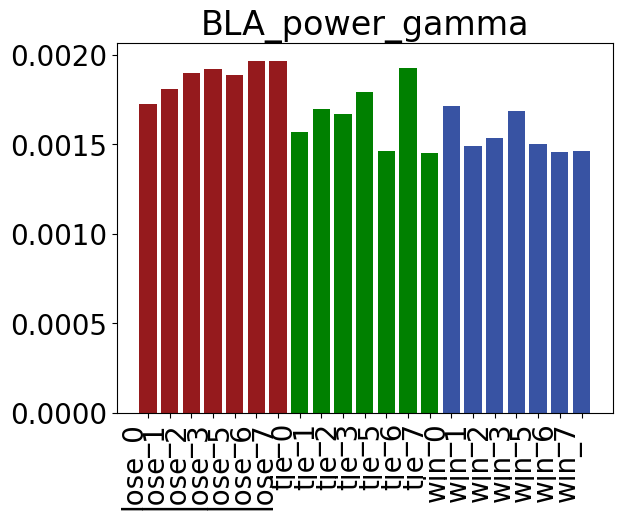

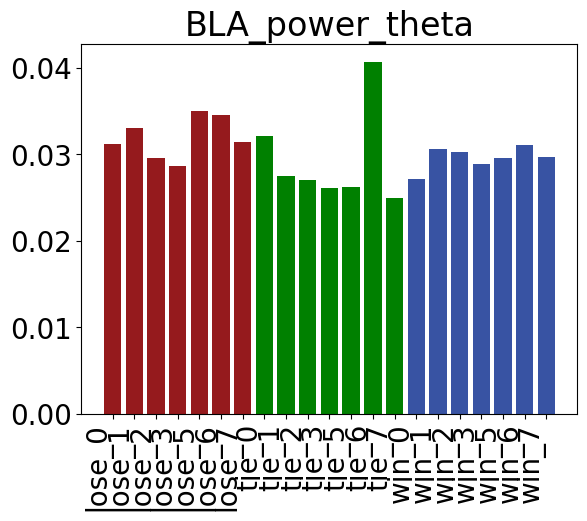

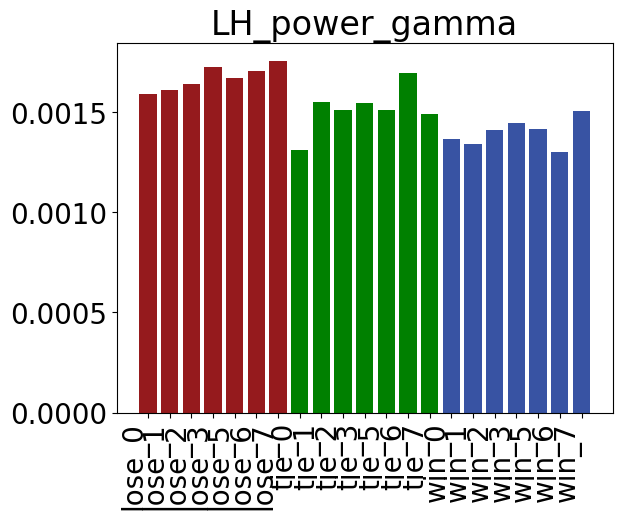

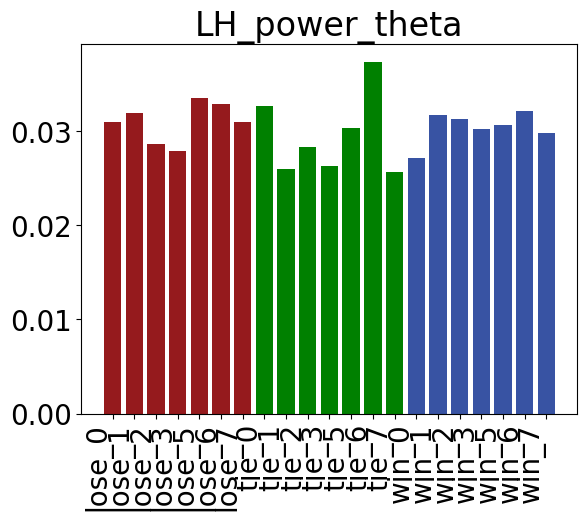

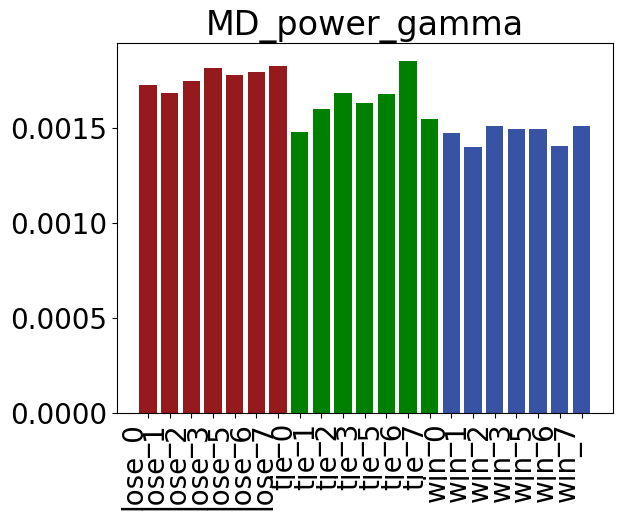

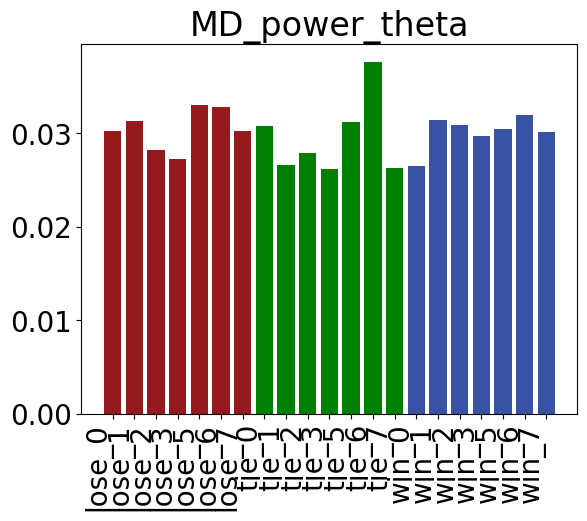

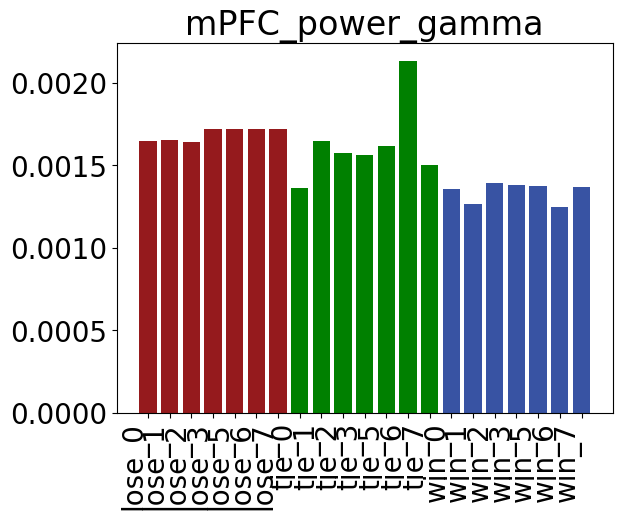

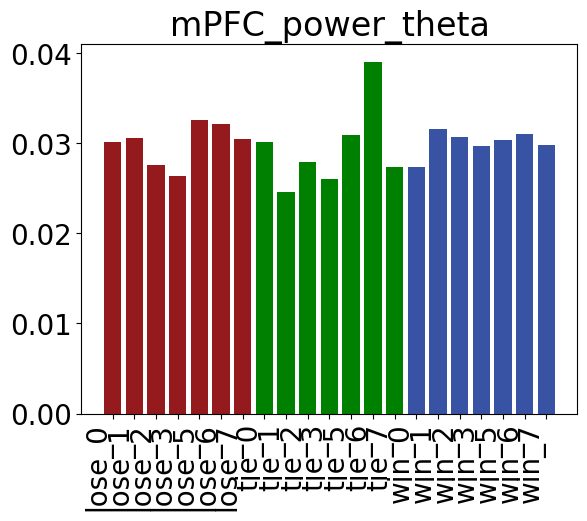

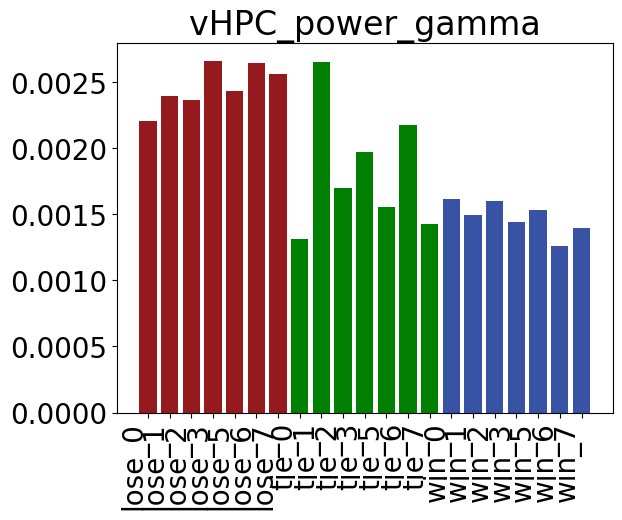

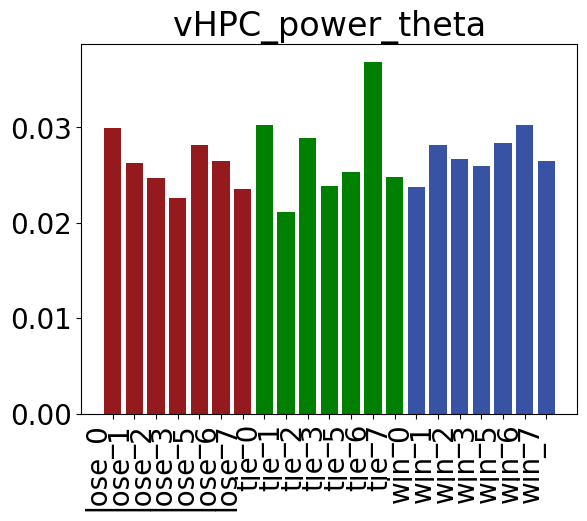

In [116]:
for col in cluster_mean_columns:
    if "all_frequencies" in col:
        continue
    grouped_power_exploded_TRIALS_AND_SPECTRAL_DF = pd.DataFrame(power_exploded_TRIALS_AND_SPECTRAL_DF.groupby('power_cluster_id')[col].mean())
    grouped_power_exploded_TRIALS_AND_SPECTRAL_DF = grouped_power_exploded_TRIALS_AND_SPECTRAL_DF.reset_index()



    grouped_power_exploded_TRIALS_AND_SPECTRAL_DF["sem"] = grouped_power_exploded_TRIALS_AND_SPECTRAL_DF["power_cluster_id"].map(power_exploded_TRIALS_AND_SPECTRAL_DF.groupby('power_cluster_id')[col].sem().to_dict())
    grouped_power_exploded_TRIALS_AND_SPECTRAL_DF["color"] = grouped_power_exploded_TRIALS_AND_SPECTRAL_DF["power_cluster_id"].apply(lambda x: x.split("_")[0]).map(OUTCOME_TO_COLOR)
    grouped_power_exploded_TRIALS_AND_SPECTRAL_DF["id_number"] = grouped_power_exploded_TRIALS_AND_SPECTRAL_DF["power_cluster_id"].apply(lambda x: x.split("_")[0]).map(OUTCOME_TO_COLOR)

    
    
    fig, ax = plt.subplots()
    plt.bar(grouped_power_exploded_TRIALS_AND_SPECTRAL_DF["power_cluster_id"], grouped_power_exploded_TRIALS_AND_SPECTRAL_DF[col], color=grouped_power_exploded_TRIALS_AND_SPECTRAL_DF["color"])
    plt.title(col.replace("cluster_mean_trial_and_post_", "").replace("RMS_filtered_", ""))
    plt.xticks(rotation=90, ha='right')
    plt.show()

In [117]:
# Define a function to horizontally stack arrays
def stack_arrays(arrays):
    return np.vstack(arrays)

In [140]:
BAND_TO_FREQ_PLOT = {'theta': (4, 12), 'gamma': (30, 50)}
BAND_TO_FREQ_COLOR = {'theta': "red", 'beta': "blue", 'gamma': "green"}

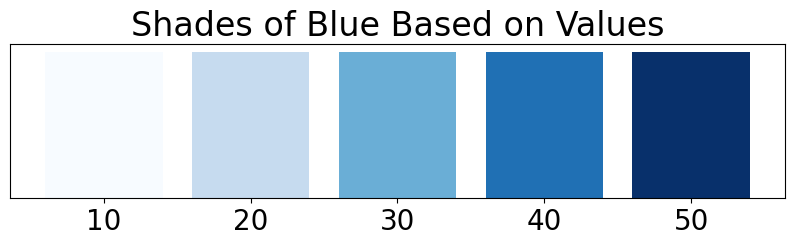

In [159]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# Sample data: a list of numbers
numbers = [10, 20, 30, 40, 50]

# Setting up the color map: using 'Blues' but you can change to 'Greens', 'Reds', etc.
cmap = plt.cm.Blues

# Normalizing the numbers to fit the color map scale
norm = Normalize(vmin=min(numbers), vmax=max(numbers))
scalar_map = ScalarMappable(norm=norm, cmap=cmap)

# Getting colors from the color map
colors = scalar_map.to_rgba(numbers)

# Plotting
plt.figure(figsize=(10, 2))
plt.bar(range(len(numbers)), [1]*len(numbers), color=colors, tick_label=numbers)
plt.title('Shades of Blue Based on Values')
plt.gca().get_yaxis().set_visible(False)  # Hide the y axis
plt.show()

In [160]:
colors

array([[0.96862745, 0.98431373, 1.        , 1.        ],
       [0.77524029, 0.85830065, 0.9368243 , 1.        ],
       [0.41708574, 0.68063053, 0.83823145, 1.        ],
       [0.12710496, 0.44018454, 0.70749712, 1.        ],
       [0.03137255, 0.18823529, 0.41960784, 1.        ]])

In [151]:
row

power_cluster_id                                                                                                               win_0
cluster_mean_trial_and_post_vHPC_RMS_filtered_power_all_frequencies_all_windows    [[0.0056280266, 0.0045099426, 0.0054150023, 0....
id_number                                                                                                                          0
trial_label                                                                                                                      win
color                                                                                                                        #3853a3
Name: 14, dtype: object

In [156]:
import seaborn as sns


In [167]:
sem_power = stats.sem(row[col], axis=0, ddof=0)

KeyError: 'cluster_mean_trial_and_post_vHPC_RMS_filtered_power_theta'

In [173]:
sem_power

array([6.4027560e-04, 5.7838287e-04, 1.1349234e-03, 1.8509253e-03,
       2.6871914e-03, 3.1011230e-03, 2.7809751e-03, 1.8896352e-03,
       1.9433588e-03, 2.0804519e-03, 1.7965502e-03, 1.0967270e-03,
       5.5918668e-04, 4.1618370e-04, 3.1552929e-04, 2.9058458e-04,
       2.7363069e-04, 2.9746373e-04, 2.8128983e-04, 3.2895684e-04,
       3.1952589e-04, 2.7740168e-04, 2.6051336e-04, 2.1805942e-04,
       2.0195064e-04, 1.8843988e-04, 2.1838139e-04, 2.2354010e-04,
       1.8709844e-04, 1.8518837e-04, 1.7042880e-04, 2.2412454e-04,
       2.5498867e-04, 2.4044252e-04, 1.3891811e-04, 1.4673988e-04,
       1.7686849e-04, 1.4426050e-04, 9.9137273e-05, 1.1363763e-04,
       1.0361276e-04, 1.1894232e-04, 1.3628523e-04, 9.9444347e-05,
       1.3591377e-04, 1.6163493e-04, 1.8719875e-04, 1.7114490e-04,
       1.9777630e-04, 1.0015705e-04, 1.1254439e-04], dtype=float32)

cluster_mean_trial_and_post_BLA_RMS_filtered_power_all_frequencies_all_windows


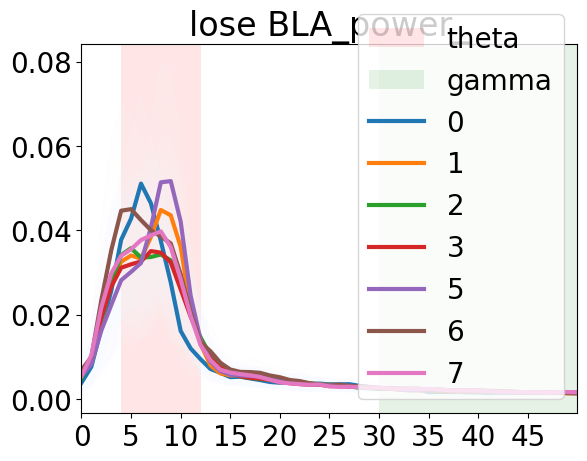

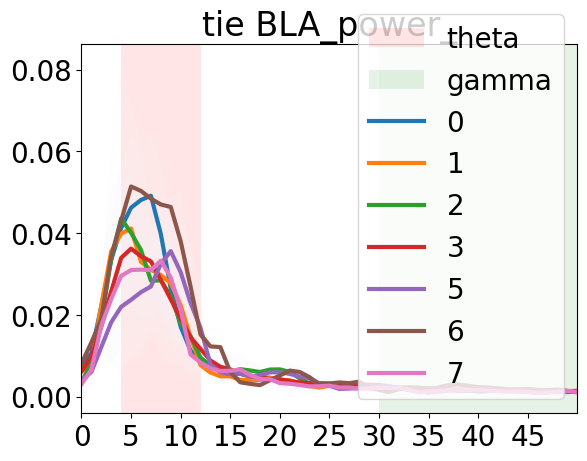

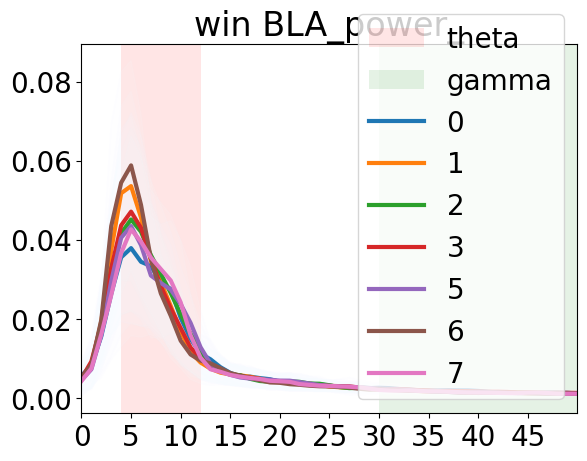

cluster_mean_trial_and_post_LH_RMS_filtered_power_all_frequencies_all_windows


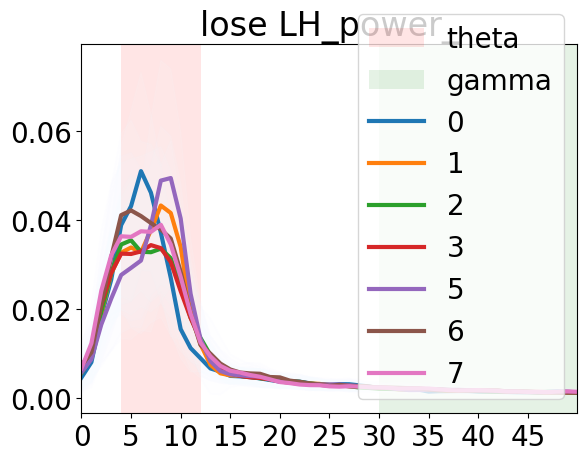

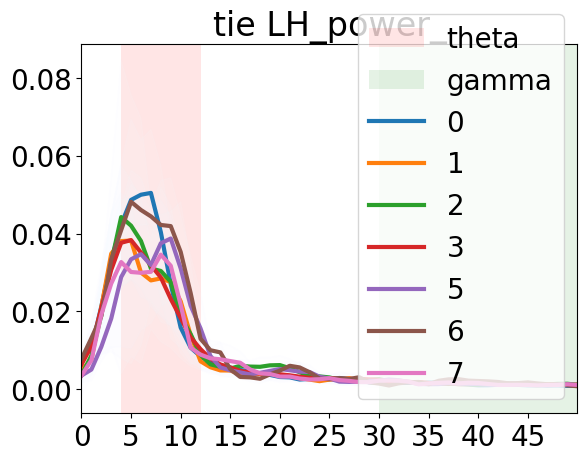

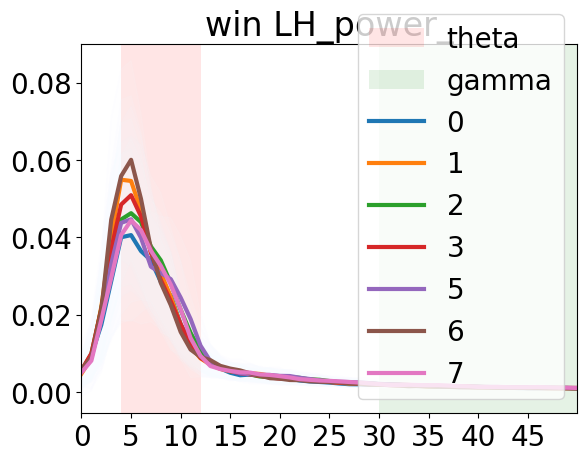

cluster_mean_trial_and_post_MD_RMS_filtered_power_all_frequencies_all_windows


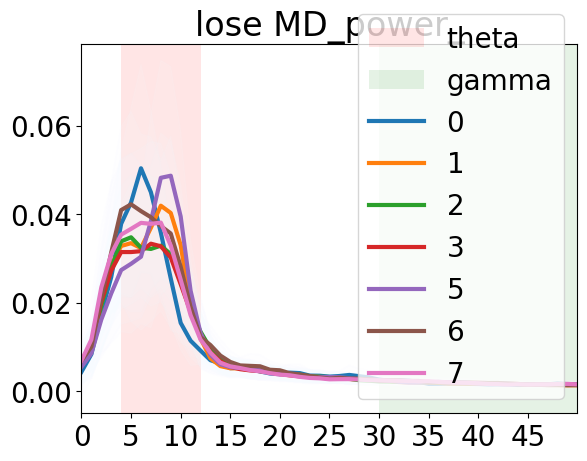

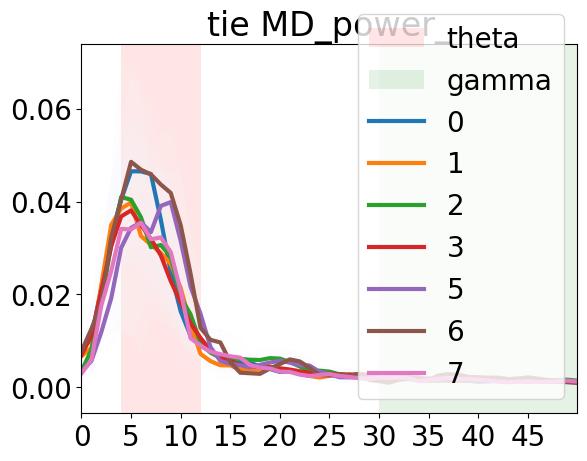

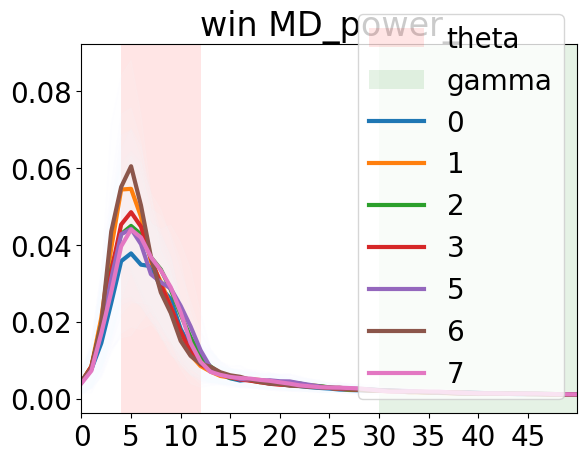

cluster_mean_trial_and_post_mPFC_RMS_filtered_power_all_frequencies_all_windows


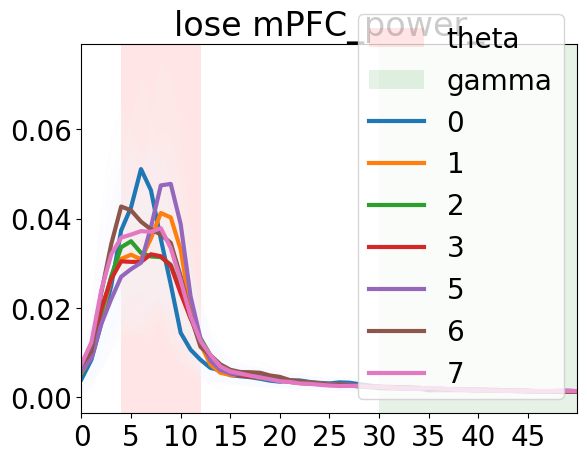

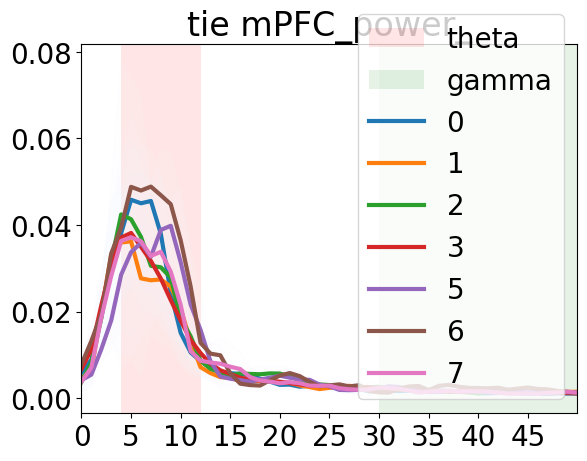

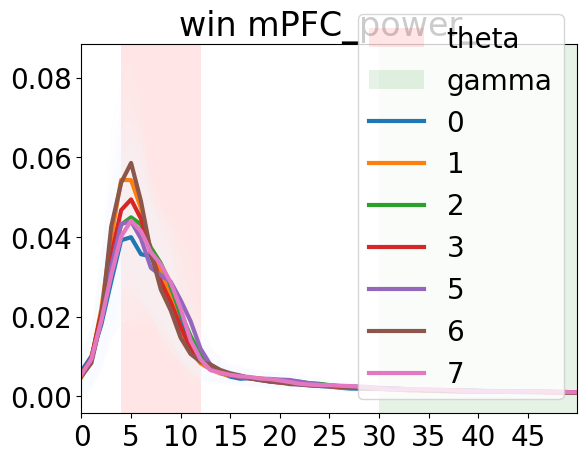

cluster_mean_trial_and_post_vHPC_RMS_filtered_power_all_frequencies_all_windows


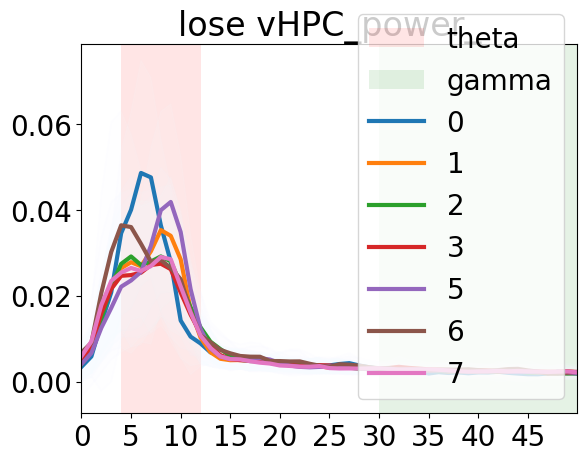

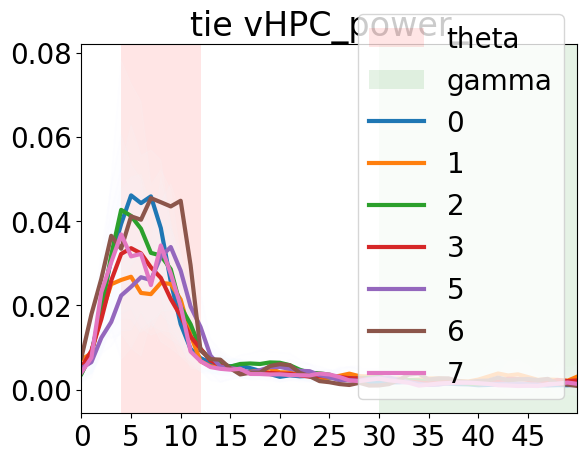

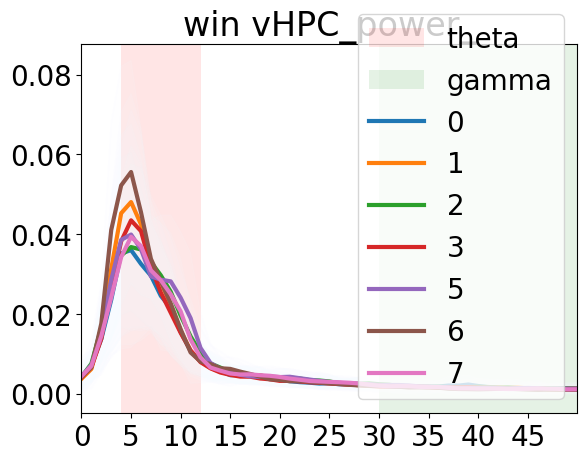

In [174]:
low_freq = 0
high_freq = 51
current_frequencies = range(low_freq, high_freq)

for col in cluster_mean_columns:
    if "all_frequencies" not in col:
        continue
    print(col)

    stacked_df = power_exploded_TRIALS_AND_SPECTRAL_DF.groupby("power_cluster_id").agg({col: stack_arrays})
    stacked_df = stacked_df.reset_index()
    
    # grouped_power_exploded_TRIALS_AND_SPECTRAL_DF["sem"] = grouped_power_exploded_TRIALS_AND_SPECTRAL_DF["power_cluster_id"].map(power_exploded_TRIALS_AND_SPECTRAL_DF.groupby('power_cluster_id')[col].sem().to_dict())
    stacked_df["id_number"] = stacked_df["power_cluster_id"].apply(lambda x: x.split("_")[1])
    stacked_df["trial_label"] = stacked_df["power_cluster_id"].apply(lambda x: x.split("_")[0])
    stacked_df["color"] = stacked_df["trial_label"].map(OUTCOME_TO_COLOR)

    for trial_label in stacked_df["trial_label"].unique():
        current_df = stacked_df[stacked_df["trial_label"] == trial_label]
        fig, ax = plt.subplots()

        plt.xlim(low_freq, high_freq-1) 
        plt.xticks(np.arange(low_freq, high_freq-1, 5))

        for band, (min_freq, max_freq) in BAND_TO_FREQ_PLOT.items():
            ax.axvspan(min_freq, max_freq, facecolor=BAND_TO_FREQ_COLOR[band], alpha=0.1, label=band)
    
        if "power" in col:
            # plt.ylim(0,0.01)
            # plt.yscale("log")
            # plt.ylim((10**-3.5,10**-0.5))
            ax.set_ylim(auto=True)
            pass
        else:
            # pass
            plt.ylim(0, 1)

        current_df["id_number"] = current_df["id_number"].astype(int)
        # Sample data: a list of numbers
        
        # Setting up the color map and normalization
        cmap = plt.cm.Blues
        norm = Normalize(vmin=current_df["id_number"].min(), vmax=current_df["id_number"].max())
        scalar_map = ScalarMappable(norm=norm, cmap=cmap)

        # Mapping values to colors
        current_df['Colors'] = current_df["id_number"].apply(lambda x: scalar_map.to_rgba(x))


        
        for index, row in current_df.iterrows():   
            #### DURING TRIAL ####
            mean_power = np.nanmean(row[col], axis=0)[low_freq: high_freq]
            
            # nans, x= nan_helper(mean_power)
            # mean_power[nans]= np.interp(x(nans), x(~nans), mean_power[~nans])
            # sem_power = stats.sem(row[col], axis=0, ddof=0)
            
            sem_power = np.nanstd(row[col], axis=0) #/ ((row[col].shape[0])**0.5)
            sem_power = sem_power[low_freq: high_freq]
            # nans, x= nan_helper(sem_power)
            # sem_power[nans]= np.interp(x(nans), x(~nans), sem_power[~nans])   
            

            ax = sns.lineplot(x=current_frequencies, y=mean_power, \
            label=row["id_number"], linewidth=3, palette=current_df['Colors'])

            plt.fill_between(current_frequencies, 
            mean_power - sem_power, mean_power + sem_power, \
            alpha=0.1, color=current_df['Colors'])
        plt.title("{} {}".format(trial_label, col.replace("cluster_mean_trial_and_post_", "").replace("RMS_filtered_", "").replace("all_frequencies_all_windows", "")))

        plt.show()
    
    







In [163]:
colors

array([[0.96862745, 0.98431373, 1.        , 1.        ],
       [0.8584083 , 0.91344867, 0.96456747, 1.        ],
       [0.73094963, 0.83947712, 0.92132257, 1.        ],
       [0.53568627, 0.74608228, 0.86425221, 1.        ],
       [0.16696655, 0.48069204, 0.72915033, 1.        ],
       [0.04405998, 0.33388697, 0.62445213, 1.        ],
       [0.03137255, 0.18823529, 0.41960784, 1.        ]])

In [162]:
numbers

[0, 1, 2, 3, 5, 6, 7]

In [139]:
current_df

,power_cluster_id,cluster_mean_trial_and_post_BLA_RMS_filtered_power_all_frequencies_all_windows,id_number,trial_label,color
14,win_0,"[[0.004096594, 0.0037298186, 0.005843769, 0.01...",0,win,#3853a3
15,win_1,"[[0.00023001009, 0.0028687983, 0.010113453, 0....",1,win,#3853a3
16,win_2,"[[0.011215975, 0.014675128, 0.023540378, 0.030...",2,win,#3853a3
17,win_3,"[[0.005638971, 0.0069611752, 0.011609195, 0.01...",3,win,#3853a3
18,win_5,"[[0.0036057679, 0.008792842, 0.018072547, 0.02...",5,win,#3853a3
19,win_6,"[[0.0022446746, 0.006630071, 0.013325419, 0.01...",6,win,#3853a3
20,win_7,"[[0.0006267908, 0.0036856167, 0.010750018, 0.0...",7,win,#3853a3


In [124]:
stacked_df[col].iloc[0].shape

(19, 56)

In [ ]:
low_freq = 0
high_freq = 51
current_frequencies = range(low_freq, high_freq)

for session in session_types:
    print(session)
    session_df = averaged_LFP_SPECTRAL_DF[averaged_LFP_SPECTRAL_DF["recording"].str.contains(session)].copy()
    
    # Apply the function to each group and each column
    grouped_all_trials_df = session_df.groupby("experiment_and_label").agg({col: stack_arrays for col in all_frequencies_col})

    grouped_all_trials_df = pd.DataFrame(grouped_all_trials_df).reset_index()    
    
    for column in power_columns:
        if "power" not in column:
            pass
        if "trace" in column:
            continue
        fig, ax = plt.subplots()
        print(column)
        baseline_column = "baseline_{}".format(column)
        col = "trial_{}".format(column)
        plot_title = "{}".format(column).replace("_all_frequencies", "").replace("_granger", "").replace("_power", "").replace("_coherence", "")
        if "granger" in column:
            plot_title = plot_title.replace("_", " to ")
        elif "power" in column:
            plot_title = plot_title.split("_")[0]

        elif "coherence" in column:
            plot_title = " and ".join(plot_title.split("_")[:2])
        else:
            plot_title = plot_title.replace("_", " and ")

        plt.title("{} {}".format(preprocessing_type, plot_title))
        
        plt.xlabel("Frequency (Hz)", fontsize=FONTSIZE)
        
        if "power" in column:
            plt.ylabel("Power (A.U.)", fontsize=FONTSIZE)

        elif "coherence" in column:
            plt.ylabel("Coherence", fontsize=FONTSIZE)
        
        elif "granger" in column:
            plt.ylabel("Granger", fontsize=FONTSIZE)

        else:
            plt.ylabel("(A.U.)", fontsize=FONTSIZE)

        
        plt.xlim(low_freq, high_freq-1) 
        plt.xticks(np.arange(low_freq, high_freq-1, 5))

        for band, (min_freq, max_freq) in BAND_TO_FREQ_PLOT.items():
            ax.axvspan(min_freq, max_freq, facecolor=BAND_TO_FREQ_COLOR[band], alpha=0.1, label=band)
        
        if "power" in column:
            # plt.ylim(0,0.01)
            # plt.yscale("log")
            # plt.ylim((10**-3.5,10**-0.5))
            ax.set_ylim(auto=True)
            pass
        else:
            # pass
            plt.ylim(0, 1)
            
        for index, row in grouped_all_trials_df.iterrows():   
            #### DURING TRIAL ####
            mean_power = np.nanmean(row[col], axis=0)[low_freq: high_freq]
            print(mean_power)
            
            # nans, x= nan_helper(mean_power)
            # mean_power[nans]= np.interp(x(nans), x(~nans), mean_power[~nans])
            sem_power = stats.sem(row[col], axis=0, ddof=0)
            
            # sem_power = np.nanstd(row[col], axis=0) / ((row[col].shape[0])**0.5)
            sem_power = sem_power[low_freq: high_freq]
            # nans, x= nan_helper(sem_power)
            # sem_power[nans]= np.interp(x(nans), x(~nans), sem_power[~nans])   
            
            
            baseline_mean_power = np.nanmean(row[baseline_column], axis=0)[low_freq: high_freq]
            print(mean_power)
            
            baseline_sem_power = stats.sem(row[baseline_column], axis=0, ddof=0)
            baseline_sem_power = baseline_sem_power[low_freq: high_freq]

            try:
                ax = sns.lineplot(x=current_frequencies, y=mean_power, \
                label="trial "+ " ".join("{}".format(row["experiment_and_label"]).split("_")), linewidth=3, color=OUTCOME_TO_COLOR[row["experiment_and_label"]])

                plt.fill_between(current_frequencies, 
                mean_power - sem_power, mean_power + sem_power, \
                alpha=0.1, color=OUTCOME_TO_COLOR[row["experiment_and_label"]])
                
#                 ax = sns.lineplot(x=current_frequencies, y=baseline_mean_power, \
#                 label="baseline " + " ".join("{}".format(row["experiment_and_label"]).split("_")), linewidth=3, linestyle="--", color=OUTCOME_TO_COLOR[row["experiment_and_label"]])

#                 plt.fill_between(current_frequencies, 
#                 baseline_mean_power - baseline_sem_power, baseline_mean_power + baseline_sem_power, \
#                 alpha=0.1, color=OUTCOME_TO_COLOR[row["experiment_and_label"]])
            
            
            
            
            except Exception as e: 
                print(e)
        # plt.legend(fontsize=10)
        plt.legend(fontsize=8, loc="lower center", ncols=2)

        ax.set_ylim(auto=True)
        plt.tight_layout()
        
        column = column.replace("_all_frequencies", "")
        spectra_type = column.split("_")[-1]
        brain_regions = "_".join((column.split("_")[:-1]))
        
        plt.savefig("./proc/plots/spectra/trial_type/png/{}_{}hz_{}_{}_{}_spectra.png".format(low_freq, high_freq, spectra_type, session, plot_title))
        plt.savefig("./proc/plots/spectra/trial_type/svg/{}_{}hz_{}_{}_{}_spectra.svg".format(low_freq, high_freq, spectra_type, session, plot_title))
        plt.show()
        
    

In [ ]:
grouped_power_exploded_TRIALS_AND_SPECTRAL_DF.index

In [ ]:
grouped_power_exploded_TRIALS_AND_SPECTRAL_DF.values

In [ ]:
plt.bar(grouped_power_exploded_TRIALS_AND_SPECTRAL_DF)

In [ ]:
power_exploded_TRIALS_AND_SPECTRAL_DF

In [ ]:
power_exploded_TRIALS_AND_SPECTRAL_DF

In [ ]:
raise ValueError()

- Grouping all the rows with the same video and subject together

In [ ]:
list(TRIALS_AND_SPECTRAL_DF.columns)

In [ ]:
explode_columns

In [ ]:
other_explode_columns = ["tone_stop_frame",
                         "condition ",
                         "competition_closeness",
                         "notes",
                         "10s_before_tone_frame",
                         "10s_after_tone_frame",
                        'cluster_index_ranges_dict',
 'cluster_times',
 'cluster_times_ranges_dict',
 'cluster_timestamps_ranges_dict',
 'trial_cluster_times_ranges_dict',
 'trial_cluster_timestamps_ranges_dict']

In [ ]:
filter_columns

In [ ]:
# Define columns to be transformed into numpy arrays


# Define aggregation dictionary
agg_dict = {col: list for col in explode_columns + other_explode_columns if col not in groupby_columns and col != "tone_start_frame"}

agg_dict.update({col: 'first' for col in filter_columns + ["tone_start_frame"] if col not in groupby_columns and col not in other_explode_columns})

# Apply groupby and aggregation
video_TRIALS_AND_SPECTRAL_DF = TRIALS_AND_SPECTRAL_DF.groupby(["video_name", "current_subject"]).agg(agg_dict).reset_index()


In [ ]:
video_TRIALS_AND_SPECTRAL_DF.columns

In [ ]:
video_TRIALS_AND_SPECTRAL_DF.head()

- Combining all the dictionaries together

In [ ]:
for col in [_ for _ in video_TRIALS_AND_SPECTRAL_DF if "dict" in _]:
    video_TRIALS_AND_SPECTRAL_DF[col] = video_TRIALS_AND_SPECTRAL_DF[col].apply(lambda x: combine_dicts(x))

In [ ]:
video_TRIALS_AND_SPECTRAL_DF.head()

In [ ]:
video_TRIALS_AND_SPECTRAL_DF.to_pickle("./proc/{}_cluster_ranges.pkl".format(OUTPUT_PREFIX))

# Filtering out the SLEAP posed for during trials

In [ ]:
raise ValueError()

In [ ]:
TRIALS_AND_SPECTRAL_DF

In [ ]:
TRIALS_AND_SPECTRAL_DF["video_frame"] = TRIALS_AND_SPECTRAL_DF["video_timestamps"].apply(lambda x: np.array(list(range(len(x)))) + 1)

In [ ]:
TRIALS_AND_SPECTRAL_DF["video_frame"].head().apply(lambda x: x.shape)

In [ ]:
['subject_thorax_to_agent_thorax',
 'nose_to_reward_port_sum',
 'nose_to_reward_port_diff',
 'thorax_velocity_sum',
 'thorax_velocity_diff',
 'to_reward_port_angle_sum',
 'to_reward_port_angle_diff',
 'subject_nose_to_reward_port',
 'subject_thorax_velocity',
 'subject_to_reward_port_angle',
 'agent_nose_to_reward_port',
 'agent_thorax_velocity',
 'agent_to_reward_port_angle',
 'closebool_subject_nose_to_reward_port',
 'closebool_agent_nose_to_reward_port',
 'movingbool_subject_thorax_velocity',
 'movingbool_agent_thorax_velocity',
 'manual_cluster_id',
 'standard_embedding_x',
 'standard_embedding_y',
 'kmeans_cluster',
 'subject_locations',
 'agent_locations',
 'subject_thorax',
 'subject_nose',
 'subject_tail_base',
 'agent_thorax',
 'agent_nose',
 'agent_tail_base']

In [ ]:
# sleap_columns = [col for col in TRIALS_AND_SPECTRAL_DF.columns if "locations" in col or "velocity" in col or "to_reward_port" in col or "video_frame" in col]

In [ ]:
sleap_columns = [col for col in TRIALS_AND_SPECTRAL_DF.columns if ("thorax" in col or "nose" in col or "reward_port" in col or "standard_embedding" in col or "cluster" in col or "frame_index" in col or "locations" in col or "tailbase" in col) and "timestamp" not in col]


In [ ]:
sleap_columns

In [ ]:
for col in sleap_columns:
    print(col)
    print(TRIALS_AND_SPECTRAL_DF[col].apply(lambda x: x.shape).iloc[0])

In [ ]:
for col in sorted(sleap_columns):
    updated_item_col = "trial_and_post_{}".format(col)
    print(updated_item_col)
    updated_timestamp_col = "trial_and_post_video_timestamps"
    TRIALS_AND_SPECTRAL_DF[updated_item_col] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: utilities.helper.filter_by_timestamp_range(start=x["tone_start_timestamp"], stop=x["post_trial_end_timestamp"], timestamps=x["cluster_timestamp"], items=x[col])[1], axis=1)

TRIALS_AND_SPECTRAL_DF[updated_timestamp_col] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: utilities.helper.filter_by_timestamp_range(start=x["tone_start_timestamp"], stop=x["post_trial_end_timestamp"], timestamps=x["cluster_timestamp"], items=x[col])[0], axis=1)

In [ ]:
TRIALS_AND_SPECTRAL_DF.head()

In [ ]:
TRIALS_AND_SPECTRAL_DF["trial_and_post_frame_index"].iloc[0].shape

In [ ]:
TRIALS_AND_SPECTRAL_DF = TRIALS_AND_SPECTRAL_DF.drop(columns=sleap_columns + ["cluster_timestamp"], errors="ignore")

In [ ]:
for col in TRIALS_AND_SPECTRAL_DF.columns:
    print(col)

- Filtering coherence

In [ ]:
coherence_columns = [col for col in TRIALS_AND_SPECTRAL_DF.columns if "coherence" in col and "timestamps" not in col and "calculation" not in col]

In [ ]:
coherence_columns

In [ ]:
for col in sorted(coherence_columns):
    updated_item_col = "trial_and_post_{}".format(col)
    print(updated_item_col)
    updated_timestamp_col = "trial_and_post_coherence_timestamps"
    TRIALS_AND_SPECTRAL_DF[updated_item_col] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: utilities.helper.filter_by_timestamp_range(start=x["tone_start_timestamp"], stop=x["post_trial_end_timestamp"], timestamps=x["coherence_timestamps"], items=x[col])[1], axis=1)

TRIALS_AND_SPECTRAL_DF[updated_timestamp_col] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: utilities.helper.filter_by_timestamp_range(start=x["tone_start_timestamp"], stop=x["post_trial_end_timestamp"], timestamps=x["coherence_timestamps"], items=x[col])[0], axis=1)

In [ ]:
TRIALS_AND_SPECTRAL_DF = TRIALS_AND_SPECTRAL_DF.drop(columns=coherence_columns + ["coherence_timestamps"], errors="ignore")

- Filtering Grangers

In [ ]:
granger_columns = [col for col in TRIALS_AND_SPECTRAL_DF.columns if "granger" in col and "timestamps" not in col and "calculation" not in col]

In [ ]:
granger_columns

In [ ]:
for col in sorted(granger_columns):
    updated_item_col = "trial_and_post_{}".format(col)
    print(updated_item_col)
    updated_timestamp_col = "trial_and_post_granger_timestamps"
    TRIALS_AND_SPECTRAL_DF[updated_item_col] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: utilities.helper.filter_by_timestamp_range(start=x["tone_start_timestamp"], stop=x["post_trial_end_timestamp"], timestamps=x["granger_timestamps"], items=x[col])[1], axis=1)

TRIALS_AND_SPECTRAL_DF[updated_timestamp_col] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: utilities.helper.filter_by_timestamp_range(start=x["tone_start_timestamp"], stop=x["post_trial_end_timestamp"], timestamps=x["granger_timestamps"], items=x[col])[0], axis=1)

In [ ]:
TRIALS_AND_SPECTRAL_DF = TRIALS_AND_SPECTRAL_DF.drop(columns=granger_columns + ["granger_timestamps"], errors="ignore")

In [ ]:
TRIALS_AND_SPECTRAL_DF.to_pickle(os.path.join(OUTPUT_DIR, FULL_LFP_TRACES_PKL))

- Filtering power

In [ ]:
TRIALS_AND_SPECTRAL_DF.head()

In [ ]:
power_columns = [col for col in TRIALS_AND_SPECTRAL_DF.columns if "power" in col and "timestamps" not in col and "calculation" not in col]

In [ ]:
power_columns

In [ ]:
for col in sorted(power_columns):
    updated_item_col = "trial_and_post_{}".format(col)
    print(updated_item_col)
    updated_timestamp_col = "trial_and_post_power_timestamps"
    TRIALS_AND_SPECTRAL_DF[updated_item_col] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: utilities.helper.filter_by_timestamp_range(start=x["tone_start_timestamp"], stop=x["post_trial_end_timestamp"], timestamps=x["power_timestamps"], items=x[col])[1], axis=1)

TRIALS_AND_SPECTRAL_DF[updated_timestamp_col] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: utilities.helper.filter_by_timestamp_range(start=x["tone_start_timestamp"], stop=x["post_trial_end_timestamp"], timestamps=x["power_timestamps"], items=x[col])[0], axis=1)


In [ ]:
TRIALS_AND_SPECTRAL_DF = TRIALS_AND_SPECTRAL_DF.drop(columns=power_columns + ["power_timestamps"], errors="ignore")

In [ ]:
for col in TRIALS_AND_SPECTRAL_DF:
    print(col)

# Filtering out phase

In [ ]:
lfp_columns = [col for col in TRIALS_AND_SPECTRAL_DF.columns if "trace" in col and "timestamps" not in col and "calculation" not in col]

In [ ]:
band_columns = [col for col in TRIALS_AND_SPECTRAL_DF.columns if "band" in col and "timestamps" not in col and "calculation" not in col]

In [ ]:
phase_columns = [col for col in TRIALS_AND_SPECTRAL_DF.columns if "phase" in col and "timestamps" not in col and "calculation" not in col]

In [ ]:
phase_columns = phase_columns + band_columns +lfp_columns

In [ ]:
phase_columns

In [ ]:
for col in sorted(phase_columns):
    updated_item_col = "trial_and_post_{}".format(col)
    print(updated_item_col)
    updated_timestamp_col = "trial_and_post_lfp_timestamps"
    TRIALS_AND_SPECTRAL_DF[updated_item_col] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: utilities.helper.filter_by_timestamp_range(start=x["tone_start_timestamp"], stop=x["post_trial_end_timestamp"], timestamps=x["lfp_timestamps"], items=x[col])[1], axis=1)

TRIALS_AND_SPECTRAL_DF[updated_timestamp_col] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: utilities.helper.filter_by_timestamp_range(start=x["tone_start_timestamp"], stop=x["post_trial_end_timestamp"], timestamps=x["lfp_timestamps"], items=x[col])[0], axis=1)


In [ ]:
TRIALS_AND_SPECTRAL_DF["trial_and_post_lfp_timestamps"]

In [ ]:
TRIALS_AND_SPECTRAL_DF = TRIALS_AND_SPECTRAL_DF.drop(columns=phase_columns + ["lfp_timestamps"], errors="ignore")

In [ ]:
TRIALS_AND_SPECTRAL_DF.to_pickle(os.path.join(OUTPUT_DIR, FULL_LFP_TRACES_PKL))

In [ ]:
for col in TRIALS_AND_SPECTRAL_DF:
    print(col)

In [ ]:
TRIALS_AND_SPECTRAL_DF["trial_and_post_kmeans_cluster"].iloc[0].shape

In [ ]:
raise ValueError()

# Filtering for rows that are in the video

In [ ]:
TRIALS_AND_SPECTRAL_DF["in_video"] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: x["start_frame"] <= x["trial_video_frame"][0] <= x["stop_frame"], axis=1)

In [ ]:
TRIALS_AND_SPECTRAL_DF = TRIALS_AND_SPECTRAL_DF[TRIALS_AND_SPECTRAL_DF["in_video"]].reset_index()

In [ ]:
TRIALS_AND_SPECTRAL_DF

In [ ]:
TRIALS_AND_SPECTRAL_DF.to_pickle(os.path.join(OUTPUT_DIR, FULL_LFP_TRACES_PKL))

In [ ]:
raise ValueError()

# Filtering out spikes

In [ ]:
raise ValueError()

In [ ]:
TRIALS_AND_SPECTRAL_DF["baseline_spike_times"] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: filter_spike_times(x["spike_times"], start=x["tone_start_timestamp"], stop=x["baseline_stop_timestamp"]).astype(int), axis=1)


In [ ]:
TRIALS_AND_SPECTRAL_DF["trial_spike_times"] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: filter_spike_times(x["spike_times"], start=x["tone_start_timestamp"], stop=x["tone_stop_timestamp"]).astype(int), axis=1)


In [ ]:
TRIALS_AND_SPECTRAL_DF["tone_start_timestamp"].head()

In [ ]:
TRIALS_AND_SPECTRAL_DF["baseline_stop_timestamp"].head()

In [ ]:
TRIALS_AND_SPECTRAL_DF["baseline_spike_times"].iloc[0]

In [ ]:
TRIALS_AND_SPECTRAL_DF["baseline_neuron_average_fr"] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: utilities.helper.filter_by_timestamp_range(start=x["tone_start_timestamp"], stop=x["baseline_stop_timestamp"], timestamps=x["neuron_average_timestamps"], items=x["neuron_average_fr"].T)[1], axis=1)
TRIALS_AND_SPECTRAL_DF["baseline_neuron_average_timestamp"] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: utilities.helper.filter_by_timestamp_range(start=x["tone_start_timestamp"], stop=x["baseline_stop_timestamp"], timestamps=x["neuron_average_timestamps"], items=x["neuron_average_fr"].T)[0], axis=1)

In [ ]:
TRIALS_AND_SPECTRAL_DF["trial_neuron_average_fr"] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: utilities.helper.filter_by_timestamp_range(start=x["tone_start_timestamp"], stop=x["tone_stop_timestamp"], timestamps=x["neuron_average_timestamps"], items=x["neuron_average_fr"].T)[1].T, axis=1)
TRIALS_AND_SPECTRAL_DF["trial_neuron_average_timestamp"] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: utilities.helper.filter_by_timestamp_range(start=x["tone_start_timestamp"], stop=x["tone_stop_timestamp"], timestamps=x["neuron_average_timestamps"], items=x["neuron_average_fr"].T)[0], axis=1)

In [ ]:
TRIALS_AND_SPECTRAL_DF = TRIALS_AND_SPECTRAL_DF.drop(columns=["spike_clusters", "spike_times", "neuron_average_fr", "neuron_average_timestamps",], errors="ignore")

In [ ]:
TRIALS_AND_SPECTRAL_DF["trial_neuron_average_fr"].iloc[0].shape

In [ ]:
TRIALS_AND_SPECTRAL_DF["trial_neuron_average_timestamp"].iloc[0].shape